In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os

In [2]:
import cv2
import os

def load_images_from_folder(folder_path):
  """
  This function loads all images from a folder and saves them in a list.

  Args:
      folder_path (str): The path to the folder containing the images.

  Returns:
      list: A list containing the loaded images as OpenCV image arrays.
  """

  images = []
  for filename in os.listdir(folder_path):
    # Check if the file is an image
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
      # Get the full path of the image
      image_path = os.path.join(folder_path, filename)
      # Load the image using cv2.imread
      image = cv2.imread(image_path)
      
      # Check if image loading is successful
      if image is not None:
        images.append(image)
      else:
        print(f"Error loading image: {filename}")

  return images

In [3]:
df = pd.read_csv('data/alphabet_labels.csv')

In [4]:
df

,file,label
0,image_1.png,A
1,image_2.png,A
2,image_3.png,A
3,image_4.png,A
4,image_5.png,A
...,...,...
372446,image_372447.png,Z
372447,image_372448.png,Z
372448,image_372449.png,Z
372449,image_372450.png,Z


In [5]:
def split_dataframe_by_label(df):
  """
  This function splits a dataframe containing labels (A-Z) into 26 dataframes.

  Args:
      df: A pandas dataframe with a column containing labels (A-Z). The dataframe
          should have a shape of (372451, 2) with two columns.

  Returns:
      A list of 26 dataframes, each containing rows with a specific label (A-Z).
  """

  # Extract the label column (assuming it's the second column)
  labels = df.iloc[:, 1]

  # Create a dictionary to store dataframes
  label_dataframes = {}
  for letter in range(ord('A'), ord('Z') + 1):  # Iterate through alphabets (A-Z)
    label_dataframes[chr(letter)] = df[labels == chr(letter)]  # Filter rows by label

  return list(label_dataframes.values())

In [6]:
separate_dfs = split_dataframe_by_label(df)

In [7]:
len(separate_dfs[0])

13870

In [8]:
def filter_long_dataframes(dataframes):
  """
  This function takes a list of DataFrames and returns a new list with DataFrames 
  having length less than or equal to 13000 rows.

  Args:
      dataframes: A list of pandas DataFrames.

  Returns:
      A list of pandas DataFrames with length less than or equal to 13000 rows.
  """
  filtered_dataframes = []
  for df in dataframes:
    if len(df) > 13000:  
      # Drop rows exceeding the threshold (exclusive)
      filtered_df = df.iloc[:13000] 
    else:
      filtered_df = df.copy()  # Keep original if length is within limit
    filtered_dataframes.append(filtered_df)
  return filtered_dataframes


In [9]:
separate_dfs = filter_long_dataframes(separate_dfs)

In [10]:
keys = []
values = []
for i in range(26):
    print(f"No of Images of letter {chr(65+i)} is {len(separate_dfs[i])}")
    keys.append(chr(65+i))
    values.append(len(separate_dfs[i]))
letter_Count = dict(zip(keys,values))    

No of Images of letter A is 13000
No of Images of letter B is 8668
No of Images of letter C is 13000
No of Images of letter D is 10134
No of Images of letter E is 11440
No of Images of letter F is 1163
No of Images of letter G is 5762
No of Images of letter H is 7218
No of Images of letter I is 1120
No of Images of letter J is 8493
No of Images of letter K is 5603
No of Images of letter L is 11586
No of Images of letter M is 12336
No of Images of letter N is 13000
No of Images of letter O is 13000
No of Images of letter P is 13000
No of Images of letter Q is 5812
No of Images of letter R is 11566
No of Images of letter S is 13000
No of Images of letter T is 13000
No of Images of letter U is 13000
No of Images of letter V is 4182
No of Images of letter W is 10784
No of Images of letter X is 6272
No of Images of letter Y is 10859
No of Images of letter Z is 6076


In [11]:
letter_Count

{'A': 13000,
 'B': 8668,
 'C': 13000,
 'D': 10134,
 'E': 11440,
 'F': 1163,
 'G': 5762,
 'H': 7218,
 'I': 1120,
 'J': 8493,
 'K': 5603,
 'L': 11586,
 'M': 12336,
 'N': 13000,
 'O': 13000,
 'P': 13000,
 'Q': 5812,
 'R': 11566,
 'S': 13000,
 'T': 13000,
 'U': 13000,
 'V': 4182,
 'W': 10784,
 'X': 6272,
 'Y': 10859,
 'Z': 6076}

In [12]:
lis = []
for i in range(26):
    l = list(separate_dfs[i].file)
    lis.append(l)

In [13]:
import cv2


def read_images_from_list_batched_resize_m2(filenames, folder_path, target_size=(28, 28), batch_size=4000):
  """
  This function reads images from a list of filenames and a folder path in batches,
  resizing them to a target size and storing them as NumPy arrays in a list.

  Args:
      filenames: A list of filenames for the images.
      folder_path: The path to the folder containing the images.
      target_size: A tuple representing the desired output size (width, height, channels) (default: (28, 28, 3)).
      batch_size: The number of images to read in each batch (default: 4000).

  Returns:
      A list containing the resized images as NumPy arrays.
  """

  images = []
  for i in range(0, len(filenames), batch_size):
    # Get a batch of filenames
    batch_filenames = filenames[i:i+batch_size]

    # Process the batch
    batch_images = []
    for filename in batch_filenames:
      # Construct the full path for the image
      filepath = os.path.join(folder_path, filename)
      # Read the image in color (adjust if needed)
      try:
        image = cv2.imread(filepath)  # Or adjust for mode
        if image is not None:
          # Resize the image to target size using interpolation
          resized_image = cv2.resize(image, dsize=target_size, interpolation=cv2.INTER_AREA)
          batch_images.append(resized_image)  
        else:
          print(f"Error: Could not read image - {filepath}")
      except (FileNotFoundError, cv2.error):
        print(f"Error: File not found or invalid image - {filepath}")

    # Append the processed batch to the main list
    images.extend(batch_images)

  return images


In [14]:
images_A = read_images_from_list_batched_resize_m2(lis[0],'data/alphabet_images')

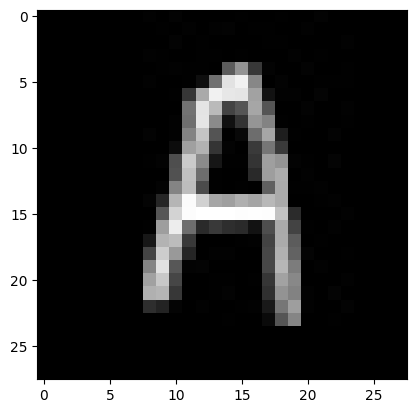

In [15]:
plt.imshow(images_A[0])

In [16]:
images_B = read_images_from_list_batched_resize_m2(lis[1],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_21694.png


In [17]:
images_C = read_images_from_list_batched_resize_m2(lis[2],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_29881.png


In [18]:
images_D = read_images_from_list_batched_resize_m2(lis[3],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_52963.png


In [19]:
images_E = read_images_from_list_batched_resize_m2(lis[4],'data/alphabet_images')

In [20]:
images_F = read_images_from_list_batched_resize_m2(lis[5],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_67913.png


In [21]:
images_G = read_images_from_list_batched_resize_m2(lis[6],'data/alphabet_images')

In [22]:
images_H = read_images_from_list_batched_resize_m2(lis[7],'data/alphabet_images')

In [23]:
images_I = read_images_from_list_batched_resize_m2(lis[8],'data/alphabet_images')

In [24]:
images_J = read_images_from_list_batched_resize_m2(lis[9],'data/alphabet_images')

In [25]:
images_K = read_images_from_list_batched_resize_m2(lis[10],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_91388.png
Error: Could not read image - data/alphabet_images\image_94883.png
Error: Could not read image - data/alphabet_images\image_96653.png


In [26]:
images_L = read_images_from_list_batched_resize_m2(lis[11],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_100563.png
Error: Could not read image - data/alphabet_images\image_106632.png


In [27]:
images_M = read_images_from_list_batched_resize_m2(lis[12],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_109239.png
Error: Could not read image - data/alphabet_images\image_114051.png


In [28]:
images_N = read_images_from_list_batched_resize_m2(lis[13],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_122177.png


In [29]:
images_O = read_images_from_list_batched_resize_m2(lis[14],'data/alphabet_images')

In [30]:
images_P = read_images_from_list_batched_resize_m2(lis[15],'data/alphabet_images')

In [31]:
images_Q = read_images_from_list_batched_resize_m2(lis[16],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_218155.png


In [32]:
images_R = read_images_from_list_batched_resize_m2(lis[17],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_223189.png
Error: Could not read image - data/alphabet_images\image_230161.png


In [33]:
images_S = read_images_from_list_batched_resize_m2(lis[18],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_243673.png
Error: Could not read image - data/alphabet_images\image_244942.png


In [34]:
images_T = read_images_from_list_batched_resize_m2(lis[19],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_284458.png
Error: Could not read image - data/alphabet_images\image_289076.png


In [35]:
images_U = read_images_from_list_batched_resize_m2(lis[20],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_308895.png
Error: Could not read image - data/alphabet_images\image_311005.png
Error: Could not read image - data/alphabet_images\image_311324.png


In [36]:
images_V = read_images_from_list_batched_resize_m2(lis[21],'data/alphabet_images')

In [37]:
images_W = read_images_from_list_batched_resize_m2(lis[22],'data/alphabet_images')

In [38]:
images_X = read_images_from_list_batched_resize_m2(lis[23],'data/alphabet_images')

In [39]:
images_Y = read_images_from_list_batched_resize_m2(lis[24],'data/alphabet_images')

Error: Could not read image - data/alphabet_images\image_365580.png


In [40]:
images_Z = read_images_from_list_batched_resize_m2(lis[25],'data/alphabet_images')

In [41]:
Images_x = [images_A,images_B,images_C,images_D,images_E,images_F,images_G,images_H,images_I,images_J,images_K,images_L,images_M,images_N,images_O,images_P,images_Q,images_R,images_S,images_T,images_U,images_V,images_W,images_X,images_Y,images_Z]

In [42]:
import numpy as np

def list_to_nd_array(Images_x):
  """
  This function converts a list of sublists representing images into a NumPy array.

  Args:
      Images_x: A list containing 26 sublists, where each sublist represents images for a letter (A-Z).

  Returns:
      A NumPy array of shape (total_images, height, width, channels), where:
          - total_images: The total number of images across all sublists.
          - height: The height of the images (assuming all images have the same height).
          - width: The width of the images (assuming all images have the same width).
          - channels: The number of color channels in the images (assuming all images have the same number of channels).
  """

  # Calculate the total number of images
  total_images = sum(len(sublist) for sublist in Images_x)

  # Check if all sublists have images (avoid empty array creation)
  if not total_images:
    raise ValueError("Input list contains no images (all sublists are empty).")

  # Get the dimensions (height, width, channels) from the first non-empty sublist
  # (assuming all images have the same dimensions)
  first_non_empty_sublist = next(sublist for sublist in Images_x if sublist)
  image_shape = np.shape(first_non_empty_sublist[0])  # Assuming first element is an image
  height, width, channels = image_shape

  # Create the NumPy array
  data_array = np.empty((total_images, height, width, channels), dtype=first_non_empty_sublist[0].dtype)

  # Fill the array with images from each sublist
  current_index = 0
  for sublist in Images_x:
    for image in sublist:
      data_array[current_index] = image
      current_index += 1

  return data_array



In [43]:
data = list_to_nd_array(Images_x)

In [44]:
data.shape

(243051, 28, 28, 3)

In [45]:
y = []
for i in range(26):
    for j in range(len(Images_x[i])):
        y.append(i)

In [46]:
y_np = np.array(y)

In [47]:
y_np.shape

(243051,)

In [61]:
y[0]

0

In [65]:
# Split data and labels together using train_test_split 
X_train, X_test_val, y_train, y_test_val = train_test_split(data, y_np, test_size=0.3, random_state=42,shuffle=False)
test_val_split = 0.5
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=test_val_split, random_state=42,shuffle=False)

In [66]:
X_train.shape

(170135, 28, 28, 3)

In [67]:
X_test.shape

(36458, 28, 28, 3)

In [68]:
X_val.shape

(36458, 28, 28, 3)

In [69]:
y_train.shape

(170135,)

In [71]:
#Callbacks
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=0.001) 
mc = ModelCheckpoint('Models/7_7_24/Callback Models/Simplistic Model/best_model_2.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [es,mc]

In [72]:
import tensorflow as tf

# Assuming train_X and y_train are your training data and labels

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3)))  # Convolutional layer
model.add(tf.keras.layers.MaxPooling2D((2, 2)))  # Optional: Pooling layer for dimensionality reduction
model.add(tf.keras.layers.Flatten())  # Flatten layer to prepare for dense layers
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.15, name='layers_dropout'))
model.add(tf.keras.layers.Dense(26, activation='softmax'))  # 26 output units for 26 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [73]:
from keras.utils import normalize

In [74]:
X_train_n = normalize(X_train)
X_test_n = normalize(X_test)

In [75]:
history = model.fit(X_train_n, y_train, epochs=15, callbacks = callbacks_list , validation_data = (X_test_n,y_test))

Epoch 1/15
5315/5317 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8372 - loss: 0.5323
Epoch 1: val_accuracy improved from -inf to 0.20805, saving model to Models/7_7_24/Callback Models/Simplistic Model/best_model_2.keras
5317/5317 ━━━━━━━━━━━━━━━━━━━━ 91s 17ms/step - accuracy: 0.8372 - loss: 0.5322 - val_accuracy: 0.2080 - val_loss: 15.4730
Epoch 2/15
5316/5317 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9533 - loss: 0.1511
Epoch 2: val_accuracy improved from 0.20805 to 0.22626, saving model to Models/7_7_24/Callback Models/Simplistic Model/best_model_2.keras
5317/5317 ━━━━━━━━━━━━━━━━━━━━ 104s 20ms/step - accuracy: 0.9533 - loss: 0.1511 - val_accuracy: 0.2263 - val_loss: 20.3610
Epoch 3/15
5313/5317 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9665 - loss: 0.1050
Epoch 3: val_accuracy did not improve from 0.22626
5317/5317 ━━━━━━━━━━━━━━━━━━━━ 142s 20ms/step - accuracy: 0.9665 - loss: 0.1050 - val_accuracy: 0.2209 - val_loss: 21.9812
Epoch 4/15
5316/5317 ━━━━━━━━━━━━━━━━━━━━

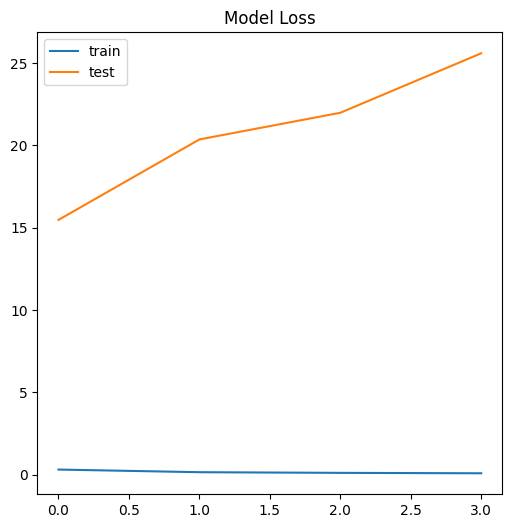

In [76]:
plt.figure(figsize = (6,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("Model Loss")
plt.show()

In [77]:
img = cv2.imread("Charecters_from_target/Words_from_line_1/1_word_0_letter_1__.jpg")

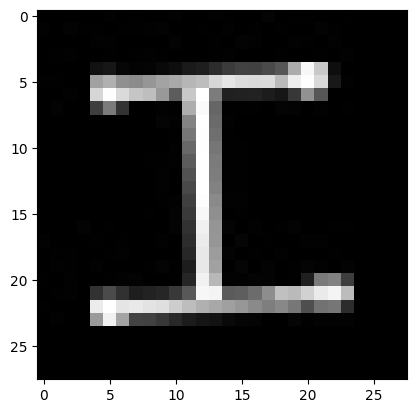

In [78]:
plt.imshow(img)

In [79]:
img_copy = np.expand_dims(img,axis=0)
model.predict(img_copy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [80]:
print(chr(65+np.argmax(model.predict(img_copy))))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
N


In [81]:
def load_images_from_folder(folder_path):
  """
  This function loads all images from a folder and saves them in a list.

  Args:
      folder_path (str): The path to the folder containing the images.

  Returns:
      list: A list containing the loaded images as OpenCV image arrays.
  """

  images = []
  for filename in os.listdir(folder_path):
    # Check if the file is an image
    if filename.lower().endswith((".jpg", ".jpeg", ".png")):
      # Get the full path of the image
      image_path = os.path.join(folder_path, filename)
      # Load the image using cv2.imread
      image = cv2.imread(image_path)
      
      # Check if image loading is successful
      if image is not None:
        images.append(image)
      else:
        print(f"Error loading image: {filename}")

  return images

In [82]:
img_list = load_images_from_folder('Charecters_from_target/Words_from_line_1')

In [83]:
def predict_list(images,model):
    string = ""
    for i in range(len(img_list)):
        img_copy = img_list[i].copy()
        img_copy = np.expand_dims(img_copy,axis=0)
        char = chr(65+np.argmax(model.predict(img_copy)))
        string = string + char
    return string    

In [84]:
p_s = predict_list(img_list,model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [85]:
print(p_s)

NNEJERGFFGRAJJSOLLJRQNSAHICHJSHERHHNHFLPFHLANDNEGAPKJGAMKEALGJANNQKEDBHPDHPCQNSJAPJDGGQMPLADNQANDJQJ
